### Importing packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns


from datetime import datetime

from IPython.core.pylabtools import figsize
from dateutil.relativedelta import relativedelta
from fontTools.subset.svg import xpath

### Defining some parameters

In [2]:
PATH = "stock-samples/MAPNA.csv"
USELESS_COLUMN_NAMES = ["<TICKER>", "<FIRST>", "<HIGH>", "<LOW>", "<VALUE>", "<VOL>", "<OPENINT>", "<PER>", "<OPEN>",
                        "<LAST>"]
DATE_COLUMN_NAME = "<DTYYYYMMDD>"
CLOSE_COLUMN_NAME = "<CLOSE>"
DATA_MAX_AGE = 5  # keep datas that are at most from 5 years ago
MOVING_AVERAGE_PAIRS = [(4, 8), (3, 5), (10, 20), (10, 30)]

### Reading sample data

In [3]:
df = pd.read_csv(PATH, index_col=None)
df

,<TICKER>,<DTYYYYMMDD>,<FIRST>,<HIGH>,<LOW>,<CLOSE>,<VALUE>,<VOL>,<OPENINT>,<PER>,<OPEN>,<LAST>
0,MAPNA,20241014,11020.0,11190.0,10870.0,11070.0,48271904560,4432100,284,D,11200.0,10870.0
1,MAPNA,20241013,11290.0,11560.0,11130.0,11200.0,175534736600,15671221,1068,D,11470.0,11130.0
2,MAPNA,20241012,11470.0,11630.0,11470.0,11470.0,760995635740,66344622,2136,D,11820.0,11470.0
3,MAPNA,20241009,11740.0,11740.0,11740.0,11820.0,30183246500,2570975,81,D,11850.0,11740.0
4,MAPNA,20241008,11750.0,11750.0,11750.0,11850.0,14253455000,1213060,62,D,11860.0,11750.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3426,MAPNA,20070902,1457.0,1457.0,1457.0,1457.0,4749522772,3259796,241,D,1429.0,1457.0
3427,MAPNA,20070901,1420.0,1431.0,1407.0,1429.0,26814720068,18758591,1468,D,1403.0,1429.0
3428,MAPNA,20070828,1406.0,1406.0,1370.0,1403.0,144131253978,102663438,7137,D,1379.0,1403.0
3429,MAPNA,20070827,1379.0,1379.0,1379.0,1379.0,19347625115,14030185,1887,D,1352.0,1379.0


### Cleaning data
Here we only keep <CLOSE> and <DTYYYYMMDD> columns. Because we are only going to work with those columns.  

In [4]:
df.drop(USELESS_COLUMN_NAMES, axis=1, inplace=True)
df

,<DTYYYYMMDD>,<CLOSE>
0,20241014,11070.0
1,20241013,11200.0
2,20241012,11470.0
3,20241009,11820.0
4,20241008,11850.0
...,...,...
3426,20070902,1457.0
3427,20070901,1429.0
3428,20070828,1403.0
3429,20070827,1379.0


Converting date column (DTYYYYMMDD) to date column 

In [5]:
df['date'] = pd.to_datetime(df[DATE_COLUMN_NAME], format='%Y%m%d', errors='coerce')
df.drop(DATE_COLUMN_NAME, axis=1, inplace=True)

df.rename(columns={CLOSE_COLUMN_NAME: 'price'}, inplace=True)  # only renaming a column in order to be comfortable with
df

,price,date
0,11070.0,2024-10-14
1,11200.0,2024-10-13
2,11470.0,2024-10-12
3,11820.0,2024-10-09
4,11850.0,2024-10-08
...,...,...
3426,1457.0,2007-09-02
3427,1429.0,2007-09-01
3428,1403.0,2007-08-28
3429,1379.0,2007-08-27


Now as we were told to just keep last five years data,so we remove data that are from before past five years

In [12]:
curr_date = datetime.now().date()
oldest_date = curr_date - relativedelta(years=5)
oldest_date_dt64 = np.datetime64(oldest_date)

df = df[df['date'] > oldest_date_dt64]
df

,price,date
1096,8499.0,2019-10-15
1095,8672.0,2019-10-16
1094,8297.0,2019-10-20
1093,8336.0,2019-10-21
1092,8649.0,2019-10-22
...,...,...
4,11850.0,2024-10-08
3,11820.0,2024-10-09
2,11470.0,2024-10-12
1,11200.0,2024-10-13


Sorting dataframe by dates ascending

In [14]:
df.sort_values(by='date', ascending=True, inplace=True, ignore_index=True)
df

,price,date
0,8499.0,2019-10-15
1,8672.0,2019-10-16
2,8297.0,2019-10-20
3,8336.0,2019-10-21
4,8649.0,2019-10-22
...,...,...
1092,11850.0,2024-10-08
1093,11820.0,2024-10-09
1094,11470.0,2024-10-12
1095,11200.0,2024-10-13


(array([17897., 18262., 18628., 18993., 19358., 19723., 20089.]),
 [Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023'),
  Text(19723.0, 0, '2024'),
  Text(20089.0, 0, '2025')])

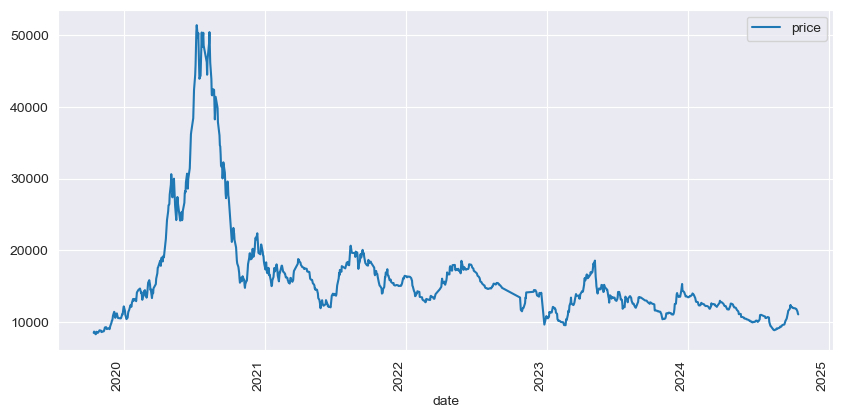

In [38]:
df.plot(x='date', y='price', figsize=(10, 5))
plt.xticks(rotation='vertical')

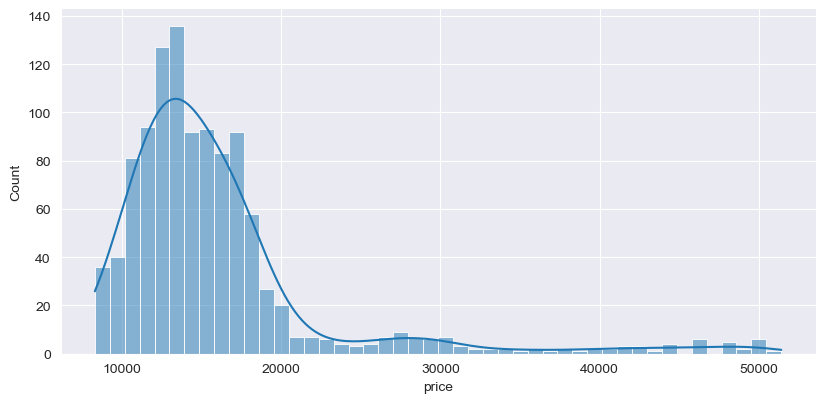

In [65]:
sns.displot(df['price'], kde=True).fig.set_size_inches(9, 4)

<Axes: xlabel='date', ylabel='price'>

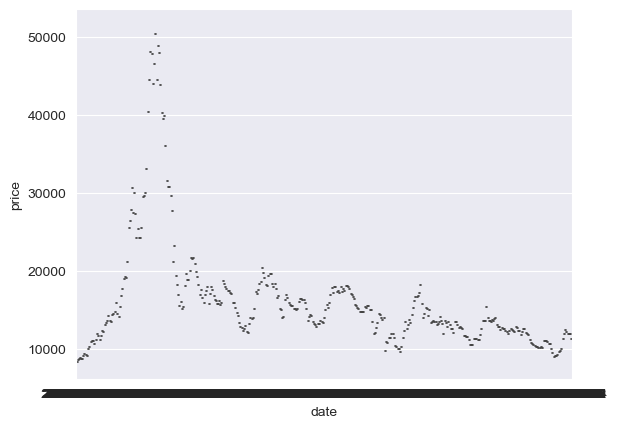

In [70]:
sns.violinplot(x='date', y='price', data=df)

<Axes: >

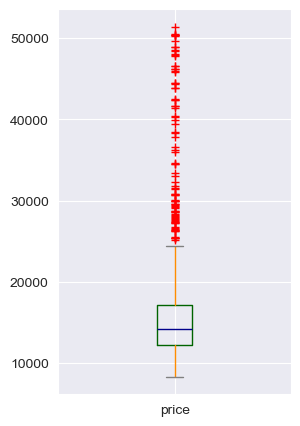

In [82]:
color = {
    "boxes": "DarkGreen",
    "whiskers": "DarkOrange",
    "medians": "DarkBlue",
    "caps": "Gray",
}
df.plot.box(color=color, sym="r+", figsize=(3, 5))